In [1]:
#pip install keras-tqdm

In [2]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [3]:
#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
train = pd.read_csv('EMNIST/emnist-balanced-train.csv')
test = pd.read_csv('EMNIST/emnist-balanced-test.csv')
mapping = pd.read_csv("EMNIST/emnist-balanced-mapping.txt", 
                      delimiter = ' ', 
                      index_col=0, 
                      header=None, 
                      squeeze=True)

(18799, 785)


In [6]:
train.shape, test.shape, mapping.shape

((112799, 785), (18799, 785), (47,))

In [7]:
WIDTH = 28
HEIGHT = 28

In [8]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

del train
del test

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((112799, 784), (112799,), (18799, 784), (18799,))

<class 'numpy.ndarray'>


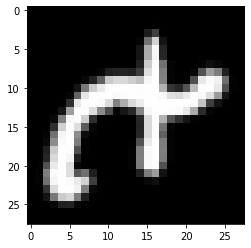

In [12]:
sample = X_train.loc[28]
plt.imshow(sample.values.reshape(28, 28), cmap=plt.cm.gray)

print(type(sample.values))
# sample.values, sample.shape

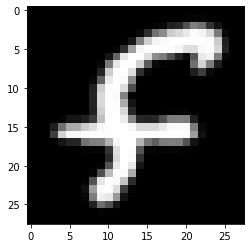

In [10]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

plt.imshow(rotate(sample.values), cmap=plt.cm.gray)

In [11]:
X_train = np.apply_along_axis(rotate, 1, X_train.values)
X_test = np.apply_along_axis(rotate, 1, X_test.values)

In [12]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

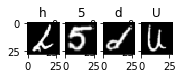

In [13]:
for i in range(100, 104):
    plt.subplot(390 + (i+1))
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.title(chr(mapping[y_train[i]]))
#     print(X_train[i])

In [14]:
number_of_classes = y_train.nunique()

# One Hot Encoding
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

y_train.shape, y_test.shape

((112799, 47), (18799, 47))

In [15]:
# Reshape train image for CNN input
# Tensorflow (batch, width, height, channels)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [16]:
# partition to train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size= 0.10, 
                                                  random_state=88)

In [17]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(47, activation = "softmax"))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)       

In [19]:
weights_directory = "Weights/"

optimizer_name = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

model_name = weights_directory+optimizer_name+"_EMNIST_Model"

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint(model_name+'.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

In [ ]:
history = model.fit(X_train,
                    y_train, 
                    epochs=30, 
                    batch_size=16, 
                    verbose=2, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, mcp_save, TQDMNotebookCallback()])

Train on 101519 samples, validate on 11280 samples


Epoch 1/30


 - 5403s - loss: 0.6674 - acc: 0.7867 - val_loss: 0.3944 - val_acc: 0.8594

Epoch 00001: val_loss improved from inf to 0.39440, saving model to Weights/adam_EMNIST_Model.h5
Epoch 2/30


In [ ]:
history.history

In [ ]:
#%%
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

In [ ]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

In [ ]:
# loss curve
plotgraph(epochs, loss, val_loss)

In [ ]:
model.save(model_name'.h5')  

In [ ]:
from keras.models import load_model

loaded_model = load_model(weights_directory+optimizer_name+"_EMNIST_Model.h5')

In [21]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [22]:
y_pred.shape

(18799, 47)

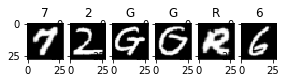

In [23]:
for i in range(10, 16):
    plt.subplot(380 + (i%10+1))
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(chr(mapping[y_pred[i].argmax()]))

In [24]:
model.evaluate(X_test, y_test)

18799/18799 [==============================] - 1820s 97ms/step


[0.41297314188614687, 0.8574392255002294]